# Machine learning strategies for time series forecasting
__Damian Leśniak, Igor Podolak__

<div id="toc"></div>

In [4]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [129]:
%pylab inline
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

Populating the interactive namespace from numpy and matplotlib


In [135]:
from sklearn.metrics import accuracy_score, brier_score_loss, classification_report
from sklearn.metrics import confusion_matrix, log_loss

> Time series: a sequence S of historical measurements $y_t$ of an observable variable $y$

Let there be a _dynamical system_ whose state evolves in a state space $\Gamma\subset\mathbb{R}^G$ according to $$s(t)=\mathcal{F}^t(s(0))$$

* In the absence of _noise_ the time series is related to dynamical system by relation $$y_t=\mathcal{G}(s(t))$$ where $$\mathcal{G}:\Gamma\rightarrow{}\mathbb{R}^D$$ is a measurement function (let $D=1$)
  * if $D=1$ then we have __univariate time series__

* $f:\mathbb{R}^n\rightarrow\mathbb{R}$ is induced in the space of vectors
$$y_t=f(y_{t-l}, y_{t-l-1},\dots, y_{t-l-d+1}),\tag{*}$$
where
* $(y_{t-l}, y_{t-l-1},\dots, y_{t-l-n+1})$ is the __embeding vector__,
* $l$ is the __lag time__,
* $d$ is the __order__, or __embedding dimension__, ie. number of past values used.

  * the reconstructed states can be used to __estimate__ $f$, and the $f$ can be used as alternative to $\mathcal{F}$ and $\mathcal{G}$
  * $(*)$ does not take into account __noise__, thus
  $$y_t=f(y_{t-l}, y_{t-l-1},\dots, y_{t-l-d+1})+w(t)$$
  with missing information in $w(t)$

## Auto Regressive Integrated Moving Average ARIMA model
* a time series is __stationary__ if its statistical properties are constant over time
  * is one whose properties __do not__ depend on the time at which series is observed
  * it has no trend
  * variations around its mean have a constant amplitude
  * it wiggles in consistent fashion
    * short term random time patterns look the same in some statistical sense
    
    
    
<img src="stationary.png" width="100%" />
      * (a) Dow Jones on 292 conseccutive days
        * __no__: trend rules
      * (b) daily change in Dow Jones on 292 consecutive days
        * __yes__: even though (a) was not stationary, it can be changed into stationary by differencing
      * (c) annual number of strikes in US
        * __no__: trend rules
      * (d) monthly sales of new one family hauses in the US
        * __no__: seasonal 
      * (e) price of a dozen eggs in US (inflation removed)
        * __no__: trend rules
      * (f)monthly total of pigs slaughtered in Victoria, Australia
        * __no__: trend rules
      * (g) annual total of lynx trapped in McKenzie river district in Canada
        * __yes__: the cycles are aperiodic
      * (h) monthly autralian beer production
        * __no__: seasonal 
      * (i) monthly australian electricity production
        * __no__: seasonal 
        * __no__: trend rules
        * __no__: increasing variance
* ARIMA is a class of models of forecasting time series, which can be made _stationary_
$$\hat{y}_{t+1}=\mu+\alpha_0y_t+\dots+\alpha_{d-1}y_{t-d+1}+\phi_0\epsilon_t+\dots+\phi_{d-1}\epsilon_{t-d+1}$$
* __ARIMA(p, d, q)__
  * __p__ number of autoregressive terms
  * __d__ number of nonseasonal differences needed for stationarity,
  * __q__ number of lagged forecast errors
* __ARIMA(1,0,0) first-order autoregressive__ model $$\hat{y}_{t+1}=\mu+\alpha_0y_t$$
  * last value plus some constant
  * in __second-order ARIMA(2,0,0)__ $$\hat{y}_{t+1}=\mu+\alpha_0y_t+\alpha_1y_{t-1}$$
* __ARIMA(0,1,0) random-walk__ $$\hat{y}_{t+1}=\mu+y_t$$
  * the constant term is the average period-to-period change
* __ARIMA(1,1,0) differenced first-order autoregressive__ model
$$\hat{y}_{t+1}=\mu+y_t+\alpha_0(y_t-y_{t-1})$$
  * if errors of random walk are auto-correlated, then problem can be probably fixed by adding a term with second dependent variable
  * it represents the first difference of $y$ __lagged__ by one period
* __ARIMA(0, 1,1) simple exponential smoothing with growth__
$$\hat{y}_{t+1}=\mu+y_t-\phi_0\epsilon_t=\mu+y_t-\phi_0(y_t-\hat{y}_t)$$
  * where $\epsilon_t$ is the error of prediction at tle last previous step
  

* ARIMA models accurately predict __short-term__ temporal structures
  * performance drops for long term
  * ARIMA assumes stationarity

## Multi step-ahead forecasting strategies
[after some works of Bontempi et al.]
* __multi_step__, or __long term__ prediction predicts $H$ values $$[y_{N+1},\dots,y_{N+H}],$$ where $H>1$ of a historical time series $[y_1,\dots,y_N]$

### Recursive strategy (Iterated, Multi-stage)
* single model is trained to perform __one-step ahead__ forecast
$$\boxed{y_{t+1}=f(y_t, \dots,y_{t-d+1}+w\;\;}$$
* if we forecast $H>1$ steps, the value just forecasted is __used__ as part of input for next predictions
$$\boxed{
\hat{y}_{N+h}=
\begin{cases}
\hat{f}(y_N,\dots,y_{N-d+1}),& \text{if } h=1\\
\hat{f}(\hat{y}_{N+h-1},\dots,\hat{y}_{N+1},y_N,\dots,y_{N-d+h}),&\text{if } h\in\{2,\dots,d\}\\
\hat{f}(\hat{y}_{N+h-1},\dots,\hat{y}_{N+h-d})&\text{if }h\in\{d+1,\dots,H\}
\end{cases}\;\;}$$
  * recursive strategy depends on noise present
  * if __forecasting horizon__ $h$ exceeds $d$ (__embedding dimension__), then some future points will be predicted __solely__ on forecasted values!
  * accumulation of errors __with__ the forecasting horizon
  * ML methods frequently used
    * neural networks
    * nearest-neighbours

### Direct strategy (Independent)
* forecast __each__ horizon independently from others
* train $H$ models $f_h$ $$\boxed{\hat{y}_{N+h}=\hat{f}_h(y_N,\dots,y_{N-d+1})\;\;}$$
  * no previously approximated values are used as input (as in recursive)
* $H$ models are trained __independently__
  * conditional independence of forecasts is induced
  * strategy does not take into account dependencies between $\hat{y}_{N+h}$
    * e.g. let the best forecasted sequence be linear
    * Direct might return a "broken" curve
  * many models have to be learned
* ML methods frequently used
  * neural networks
  * nearest neighbours
  * decision trees


###  DirRec
* combines Direct and Recursive strategies
  * compute forecasts with different models for every horizon (as Direct)
  * at each step enlarges inputs with forecasts of previous step (like Recursive)
  $$\boxed{
  \hat{y}_{N+h}=\hat{f}_h(y_{N+h-1},\dots,y_{N-d+1})\;\;}$$ for $t\in\{d, N-H\}$ and $h\in\{1, H\}$
  * we have to learn models
  $$\boxed{
\hat{y}_{N+h}=
\begin{cases}
\hat{f}(y_N,\dots,y_{N-d+1}),& \text{if } h=1\\
\hat{f}(\hat{y}_{N+h-1},\dots,\hat{y}_{N+1},y_N,\dots,y_{N-d+h}),&\text{if } h\in\{2,\dots,d\}
\end{cases}\;\;}$$
  * forecasts from previous steps are added
  * embedding size __is not the same__ for all horizons
  ---
  * DirRec outperformed previous approaches on some datasets
  * not so popular yet - young

### MIMO Multi-Input Multi-Output (or Joint)
* previous are combinations of single output approaches
* idea: learn prediction which __does not avoid existence of stochastic dependencies between future values__
$$\boxed{
[\hat{y}_{N+H},\dots,\hat{y}_{N+1}]=\hat{f}(y_N,\dots,y_{N-d+1})
\;\;}$$
* should preserve dependencies between predicted values
* avoids 
  * conditional independence assumption (like it is in Direct)
  * accumulation of errors (as it is in Recursive)
* all horizons predicted with the same model structure - may be a drawback
* several succesfull applications 

### DIRMO 
* to preserve pros of DIRect and miMO
  * forecast $H$ outputs in $n$ blocks each of size $s$ ($H = n * s$)
  * $s\in\{1,\dots,H\}$
    * the blocks do not overlap
    * how about overlapping blocks?
    * or blocks that are "mixed", eg. 
    $$\begin{align}
    b_1=[\hat{y}_{N+1},\hat{y}_{N+3},\hat{y}_{N+6},\hat{y}_{N+10}]\\
    b_2=[\hat{y}_{N+2},\hat{y}_{N+4},\hat{y}_{N+7},\hat{y}_{N+11}]\\
    b_3=[\hat{y}_{N+3},\hat{y}_{N+5},\hat{y}_{N+8},\hat{y}_{N+12}]\\
    b_4=[\hat{y}_{N+4},\hat{y}_{N+6},\hat{y}_{N+9},\hat{y}_{N+13}]
    \end{align}$$
* the output block size needs to be calibrated, eg. some sort of cross validation
  * may give trade-off between
    * stochastic dependency bewteen future values
    * flexibility of predictor

### Speed comparison
* training of multi-output is longer than single output
* multi prediction depends on number of models needed, thus
  * Recursive is the fastest
  * MIMO second fastest
  * DIRMO third (only $H/s$ models)
  * Direct next ($H$ single-output models)
  * DirRec last ($H$ single output models because of change of embedding size)
* DIRMO may be slowest because of the need to tune block size $s$

### Comparisons
* __Recursive__
  * good for noise free environments, 
  * __but__ accumulates error
* __Direct__
  * does not accumulate errors,
  * __But__ but assumes conditional independence of outputs
* __DirRec__
  * is a trade-off between Recursive and Direct, 
  * __but__ input grows with $H$
* __MIMO__
  * does not assume conditional independence of outputs, 
  * __but__ has reduced flexibility because of the same model for all horizons
* __DIRMO__
  * is a trade-off between independence and dependence of outputs,
  * __but__ needs block size tuning

## ML approximation methods used in time series forecasting

### Nearest Neighbour KNN
* find the pattern in history nearest to $[y_t,y_t-1,\dots,y_{t-d+1}]$
* select as  output the value $y_p$
  * consider more neighbours

### Lazy Learning LL
* local method which adapts the size of neighbourhood on the basis of a cross-validation criterion
* let $x_q=[y_t,\dots,y_{t-d+1}]$ be the __query__
  1. sort increasingly vectors $y_{[1]},y_{[2]},y_{[3]},\dots$ in $X$ with respect to distance to $x_q$
  2. determine optimal number $k$ of neighbours, e.g. using PRESS statistic:
    1. estimate $$\hat{y}^{(k)}_q=\frac{1}{k}\sum y_{[j]}$$
    2. where $k$ is estimated from error $e_{LOO}$ (Leave-One-Out)
    $$\begin{align}
    e_{LOO}(k)&=\frac{1}{k}\sum_j^k(e_j(k))^2\\
    e_j(k))&=y_{[j]}-\frac{\sum_{i\neq{}j}^k y_{[i]}}{k-1}=
    \frac{(k-1)y_{[j]}+y_{[j]}-y_{[j]}-\sum_{i\neq{}j}^k y_{[i]}}{k-1}\\
    &=\frac{ky_{[j]}-\sum_i^ky_{[i]}}{k-1}=\frac{ky_{[j]}-ky_q^{(k)}}{k-1}=k\frac{y_{[j]}-y_q^{(k)}}{k-1}\\
    k^{\ast}&=\underset{k\in\{1,\dots,K\}}{\arg\,\min}e_{LOO}(k)
    \end{align}$$
  3. calculate prediction $\hat{y}_{t+1}$
* to use lazy learning in multi-step forecasting
  * extend algorithm to us composition of one-step ahead aproach
  * use other measures of discrepancy between forecasted values and training time sereis from history
  
* two main approaches to model selection in LL
  * __winner-takes_all__ select the best $k$
  * __combine__ average models $$\hat{y}_q=\sum_{k=2}^Kp_ky_q^{(k)} \Big{/} \sum_{k=2}^Kp_k$$

### Multi layer perceptron MLP
* high number of parameters (number of hidden layers, number of neurons in layers)
* relation between inputs in the embedding is not given __explicitely__

### Bayesian Neural Network BNN
* network parameters (weights) treated as random variables obeying some _a priori_ distribution
* distribution favours models with low complexity by minimizing $$J=\alpha{}E_D+(1-\alpha)E_W$$
* given observed data, new distributions can be computed
* predictions reflect 
  * __smoothness__ imposed through the prior
  * __fitness accuracy__ imposed by observed data

### Radial Basis Function Neural Networks RBF
* a single layer neural network with hidden layer using Gaussian type activation
$$\hat{y}(x)=\sum_j w_j\exp\left(-\frac{\|x-c_j\|^2}{\sigma^2}\right)$$

### Generalized Regression Neural Network GRNN (Nadaraya-Watson)
* prediction given by the __average__ of target outputs of training points in vicinity of $x$
* __local average__ constructed by weighting points by their distance from $x$ using some kernel function
$$\boxed{
\begin{align}
\hat{y}(x)&=\sum_jw_jy_j\\
w_j(x)&=\frac{K\left(\frac{\|x-x_j\|}{h}\right)}{\sum_{k}K\left(\frac{\|x-x_k\|}{h}\right)}
\end{align}
\;\;}$$

### Classification And Regression Trees CART
* tree-like partition of the input space
* terminal leaves return a value
  * step-like function returned
* needs pruning
* low generalization

### Support Vector Regression SVR
* minimize the error function
$$J=\frac{1}{2}\|w\|^2+C\sum_j|y_j-f(x_j)|_\epsilon$$
* the model uses _support vectors_ only
$$f(x)=\sum_j(\alpha_j^*-\alpha_j)K(x_j^Tx)+b$$

### Gaussian Processes GP
* nonparametric method based on modelling observed responses of different training points as __multivariate random variable__
* posterior distribution of function to be predicted is found using assumed prior distribution

## Preprocessing
* preprocessing may have __a big impact__ on performance, eg.
  * deseasonalization of data
  * detrending
  * log-transformation
  * series differencing
    * well understood for linear models (eg. ARIMA)
    * not always a good strategy for non-stationary series
    * usually gives good results for the stationary case
  * taking moving averages
    * may smooth out noise

##  Model selection
* K-fold cross-validation is preferred
  * probably double

## Metrics
* __symmetric mean absolute precentage error SMAPE__
$$SMAPE=\frac{1}{M}\sum_m\frac{|\hat{y}_m-y_m|}{(|\hat{y}_m|+|y_m|)/2}$$
* ranking methods for comparing approaches
  * compute the rank $R_q(p)$ of each method $q$ on each time series $p$
  
---
* there are problems with comparisons
* two groups used the same deterministic algorithm (1-NN) on the same data
  * results differed by as much as 6%!
  * the only difference was that one group rounded data to 6 decimal places while the other to 8 places!

## Comparisons
[after Ahmed 2010]



|LAG|   |DIFF |    |MAVG|
---  |---  |--- |---  |--- |---  |---
     |SMAPE|Rank|SMAPE|Rank|SMAPE|Rank
MLP  |0.086|__2.78__|0.179|5.02|0.083|__2.88__
BNN  |0.103|_3.42_|0.175|4.58|0.086|__2.94__
RBF  |0.125|5.33|0.213|5.24|0.158|6.28
GRNN |0.104|5.24|0.156|__3.92__|0.103|4.99
KNN  |0.104|5.10|0.169|4.57|0.103|4.95
CART |0.121|6.77|0.152|__3.93__|0.117|6.31
SVR  |0.099|4.19|0.171|4.59|0.104|4.41
GP   |0.095|_3.17_|0.165|_4.15_|0.096|_3.26_

* best models within 95% confidence are in __bold__
* second best are given in _italics_



## Ensembles of model
[after Oliveira & Torgo]
* _embedding dimension_ is critical to solutions
* task: find an __optimal__ value for embedding dimension
  * there may not exists a __single__ correct value
  * non-stationary series and changes of regime shifts may lead to the size to be __time-dependent__
* diversity is a key ingredient to  boost performance
  * generate ensemble models of different characteristics (model tried by authors)
    1. __simple bagging__ several models of same embedding size; diversity from bootstrap samples
    2. __extra predictors__ additional predictors added; values convey information on dynamics, eg. mean and variance values for the given embedding
      * last week Damian proposed adding information on the regime a machine is working in
    3. __extended diversity__ by varying embedding dimensions; on top of bootstrap samples
    4. __extended + extra__ varying embedding dimensions plus extra predictors
    5. __extended in groups__ mixture of the last two: only half of models have extra predictor input values

In [72]:
def _ls(datasets_dir):
    return os.listdir(datasets_dir)

def load_dataset(dataset):
#    train = pd.read_csv(os.path.join(DATASETS_DIR, dataset, dataset + "_TRAIN"), header=None)
#    test = pd.read_csv(os.path.join(DATASETS_DIR, dataset, dataset + "_TEST"), header=None)
    train = pd.read_csv(os.path.join(DATASETS_DIR, dataset + "_TRAIN"), header=None)
    test = pd.read_csv(os.path.join(DATASETS_DIR, dataset + "_TEST"), header=None)

    X_train = train.ix[:,1:].values
    y_train = train[0].values
    X_test = test.ix[:,1:].values
    y_test = test[0].values
    return X_train, y_train, X_test, y_test

In [73]:
#DATASETS_DIR = "./UCR_TS_Archive_2015"
DATASETS_DIR = "."
dataset = "ElectricDevices"
X_train, y_train, X_test, y_test = load_dataset(dataset)

In [77]:
import timeit

In [75]:
print("Train: X.shape = {}, y.shape = {}".format(X_train.shape, y_train.shape))
print("Test : X.shape = {}, y.shape = {}".format(X_test.shape, y_test.shape))

Train: X.shape = (8926, 96), y.shape = (8926,)
Test : X.shape = (7711, 96), y.shape = (7711,)


# Time series classification
[after Bagnall, Bostrom, Large, Lines]

Let $(x, y)$ be an observation where $x$ is an $m$ element __time series__ TS

* let $a=[a_1,\dots,a_m], b=[b_1,\dots,b_m]$ be series that we want to measure distance between
* $M(a,b)$ is a pointwise distance matrix
  * $M_{ij}=(a_i-b_j)^2$
## Euclidean distance
  $$d_E(a,b)=\sum_i(a_i-b_i)^2$$
  * distance along the diagonal
## Dynamic Time Warping DTW
  * __warping path__ $$P=[(e_1,f_1),\dots,(e_s,f_s)]$$ is a set of pairs of indexes that define the traversal of $M$
    * $(e_1,f_1)=(1,1)$ and $(e_s,f_s)=(m, m)$: start at the first point of sequences, and end at the last
    * $0\leq{}e_{i+1}-e_i\leq1$ and $0\leq{}f_{i+1}-e_i\leq1$: stay in the same point (of $a$ or $b$) or proceed to the next
  * the distance for $P$ is $$d=\sum_iM_{a_{e_i}b_{f_i}}$$
  * DTW is the distance over path $p^\ast$ minimizing distance
  * requires dynamic programming for exact values; approximations possible

In [82]:
from dtw import dtw
from fastdtw import fastdtw

In [7]:
import numpy as np
a = np.array([0, 1, 3, 2, 3, 4]).reshape(-1, 1)
b = np.array([1, 0, 1, 1, 2, 3]).reshape(-1, 1)
m = np.zeros((len(a), len(b)))
for i in range(len(a)):
    for j in range(len(b)):
        m[i, j] = (a[i] - b[j]) ** 2
print(m)

[[  1.   0.   1.   1.   4.   9.]
 [  0.   1.   0.   0.   1.   4.]
 [  4.   9.   4.   4.   1.   0.]
 [  1.   4.   1.   1.   0.   1.]
 [  4.   9.   4.   4.   1.   0.]
 [  9.  16.   9.   9.   4.   1.]]


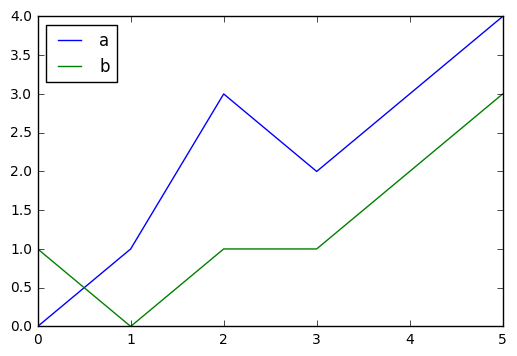

In [107]:
plot(a, label='a')
plot(b, label='b')
legend(loc='best')

In [12]:
def squared_norm(x, y):
    return (x - y) ** 2

In [13]:
def l1_norm(x, y):
    return np.abs(x - y)

In [121]:
dst, cst, acc, ptha = dtw(a, b, dist=lambda x, y: norm(x - y, ord=1))
print('dist = {}\ncost = {}\nacc = {}\npath = {}'.format(dst, cst, acc, pth))

dist = 0.25
cost = [[ 1.  0.  1.  1.  2.  3.]
 [ 0.  1.  0.  0.  1.  2.]
 [ 2.  3.  2.  2.  1.  0.]
 [ 1.  2.  1.  1.  0.  1.]
 [ 2.  3.  2.  2.  1.  0.]
 [ 3.  4.  3.  3.  2.  1.]]
acc = [[  1.   1.   2.   3.   5.   8.]
 [  1.   2.   1.   1.   2.   4.]
 [  3.   4.   3.   3.   2.   2.]
 [  4.   5.   4.   4.   2.   3.]
 [  6.   7.   6.   6.   3.   2.]
 [  9.  10.   9.   9.   5.   3.]]
path = (array([0, 0, 1, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 4, 5, 5]))


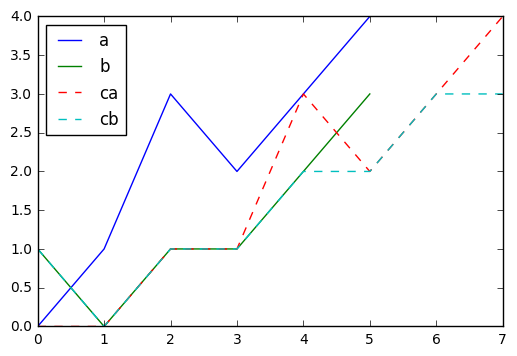

In [127]:
ca = [a[x] for x in ptha[0]]
cb = [b[x] for x in ptha[1]]
plot(a, label='a')
plot(b, label='b')
plot(ca, '--', label='ca')
plot(cb, '--', label='cb')
legend(loc='best')

In [123]:
dst, cst, acc, pthb = dtw(a, b, dist=squared_norm)
print('dist = {}\ncost = {}\nacc = {}\npath = {}'.format(dst, cst, acc, pth))

dist = 0.25
cost = [[  1.   0.   1.   1.   4.   9.]
 [  0.   1.   0.   0.   1.   4.]
 [  4.   9.   4.   4.   1.   0.]
 [  1.   4.   1.   1.   0.   1.]
 [  4.   9.   4.   4.   1.   0.]
 [  9.  16.   9.   9.   4.   1.]]
acc = [[  1.   1.   2.   3.   7.  16.]
 [  1.   2.   1.   1.   2.   6.]
 [  5.  10.   5.   5.   2.   2.]
 [  6.   9.   6.   6.   2.   3.]
 [ 10.  15.  10.  10.   3.   2.]
 [ 19.  26.  19.  19.   7.   3.]]
path = (array([0, 0, 1, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 4, 5, 5]))


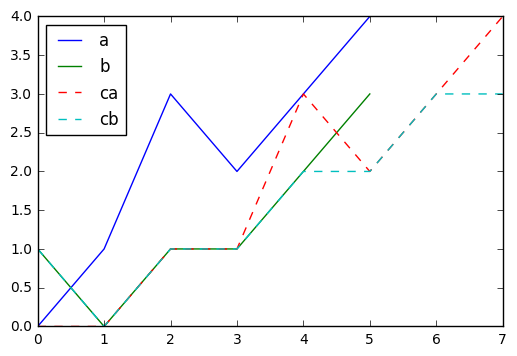

In [128]:
ca = [a[x] for x in pthb[0]]
cb = [b[x] for x in pthb[1]]
plot(a, label='a')
plot(b, label='b')
plot(ca, '--', label='ca')
plot(cb, '--', label='cb')
legend(loc='best')

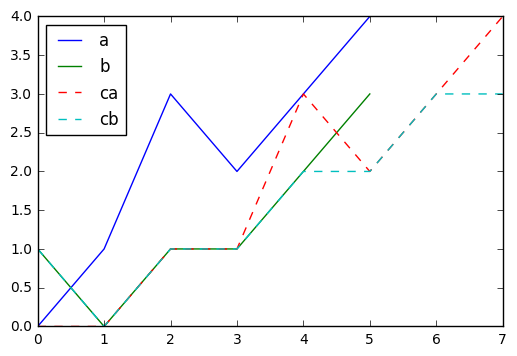

In [98]:
cst, pth = fastdtw(a, b)
ca = [a[x[0]] for x in pth]
cb = [b[x[1]] for x in pth]
plot(a, label='a')
plot(b, label='b')
plot(ca, '--', label='ca')
plot(cb, '--', label='cb')
legend(loc='best')

In [22]:
p = [[0, 0], [0, 1], [1, 2], [1, 3], [2, 4], [3, 4], [4, 5], [5, 5]]
aw = [a[x[0]] for x in p]
bw = [b[x[1]] for x in p]
print('Original TS: a = {}\n             b = {}'.format(list(a), list(b)))
print('Warped TS:   a = {}\n             b = {}'.format(aw, bw))
# dtw = np.sum([m[x[0], x[1]] for x in p])
print('DTW is {}'.format(dtw(a, b, dist=lambda x, y: norm(x - y, ord=1))))

Original TS: a = [array([0]), array([1]), array([3]), array([2]), array([3]), array([4])]
             b = [array([1]), array([0]), array([1]), array([1]), array([2]), array([3])]
Warped TS:   a = [array([0]), array([0]), array([1]), array([1]), array([3]), array([2]), array([3]), array([4])]
             b = [array([1]), array([0]), array([1]), array([1]), array([2]), array([2]), array([3]), array([3])]
DTW is (0.25, array([[ 1.,  0.,  1.,  1.,  2.,  3.],
       [ 0.,  1.,  0.,  0.,  1.,  2.],
       [ 2.,  3.,  2.,  2.,  1.,  0.],
       [ 1.,  2.,  1.,  1.,  0.,  1.],
       [ 2.,  3.,  2.,  2.,  1.,  0.],
       [ 3.,  4.,  3.,  3.,  2.,  1.]]), array([[  1.,   1.,   2.,   3.,   5.,   8.],
       [  1.,   2.,   1.,   1.,   2.,   4.],
       [  3.,   4.,   3.,   3.,   2.,   2.],
       [  4.,   5.,   4.,   4.,   2.,   3.],
       [  6.,   7.,   6.,   6.,   3.,   2.],
       [  9.,  10.,   9.,   9.,   5.,   3.]]), (array([0, 0, 1, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 4, 5, 5])))


In [85]:
def fdtw(a, b):
    return fastdtw(a, b)[0]

In [79]:
def sdtw(a, b):
    d, _, _, _ = dtw(a, b, dist=squared_norm)
    return d

In [80]:
def ldtw(a, b):
    d, _, _, _ = dtw(a, b, dist=l1_norm)
    return d

In [133]:
one_nn = KNeighborsClassifier(n_neighbors=1, metric=fdtw, n_jobs=-1)
one_nn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function fdtw at 0x116f391b8>, metric_params=None,
           n_jobs=-1, n_neighbors=1, p=2, weights='uniform')

In [134]:
predicted = one_nn.predict(X_test)

In [147]:
onn_accu = accuracy_score(y_test, predicted)
onn_conf = confusion_matrix(y_test, predicted)
# onn_log = log_loss(y_test, predicted)  # needs predict_proba
onn_report = classification_report(y_test, predicted)

In [148]:
print('1-NN with DTW accuracy: {}'.format(onn_accu))

1-NN with DTW accuracy: 0.627934120088


In [151]:
print('1-NN with DTW confusion matrix:\n {}'.format(onn_conf))

1-NN with DTW confusion matrix:
 [[ 182    0   28  147  193   96   21]
 [   0 1387    1   25  541    0    2]
 [  11    0  476   27   27    7  207]
 [  60    0  172  604  214   63   52]
 [  10   76   23  108 1608    9   35]
 [  40    0   13  138   55  493    4]
 [   3    9   11   21  420    0   92]]


In [150]:
print('1-NN with DTW report: {}'.format(onn_report))

1-NN with DTW report:              precision    recall  f1-score   support

          1       0.59      0.27      0.37       667
          2       0.94      0.71      0.81      1956
          3       0.66      0.63      0.64       755
          4       0.56      0.52      0.54      1165
          5       0.53      0.86      0.65      1869
          6       0.74      0.66      0.70       743
          7       0.22      0.17      0.19       556

avg / total       0.65      0.63      0.62      7711



## Weighted DTW
* DTW with penalty applied to warping distances $$M_{ij}=w(|i-j|)(a_i-b_j)^2$$
* usually warping penalty is some logistic function of warping distance and sequence length $$w(d)=\frac{w_{max}}{1+\exp(-g(d-m/2))}$$

## Time Warped Edit TWE
* modifies DTW
* adds some characteristics of Longest Commoon SubSequence LCSS

In [26]:
def twe(a, b, nu=1, lam=0):
    assert a.shape[0] == b.shape[0]
    d = np.zeros((a.shape[0] + 1, b.shape[0] + 1))
    d[0, 0] = 0
    d[1, 0] = a[0] ** 2
    d[0, 1] = b[0] ** 2
    for i in range(1, d.shape[0]):
        d[i, 0] = d[i - 1, 0] + (a[i - 2] - a[i - 1]) ** 2
    for j in range(1, d.shape[0]):
        d[0, j] = d[0, j - 1] + (b[j - 2] - b[j - 1]) ** 2
    for i in range(1, d.shape[0]):
        for j in range(1, d.shape[0]):
            if i > 1 and j > 1:
                dst1 = d[i - 1, j - 1] + nu * np.abs(i - j) * 2 + \
                (a[i - 1] - b[j - 1]) ** 2 + (a[i - 2]- b[j - 2]) ** 2
            else:
                dst1 = d[i - 1, j - 1] + nu * np.abs(i - j) + (a[i - 1] - b[j - 1]) ** 2
            if i > 1:
                dst2 = d[i - 1, j] + (a[i - 1] - a[i - 2]) ** 2 + lam + nu
            else:
                dst2 = d[i - 1, j] + a[i - 1] ** 2 + lam
            if j > 1:
                dst3 = d[i, j - 1] + (b[j - 1] - b[j - 2]) ** 2 + lam + nu
            else:
                dst3 = d[i, j - 1] + b[j - 1] ** 2 + lam
            d[i, j] = np.min([dst1, dst2, dst3])
    return d[d.shape[0] - 1, d.shape[0] - 1]

In [27]:
nu = 0.1; lam = 0.5
print('twe(a, b, nu={}, lam={}) = {}'.format(nu, lam, twe(a, b, nu=nu, lam=lam)))

twe(a, b, nu=0.1, lam=0.5) = 8.2


## Move-Split_Merge
* a typical edit distance based
* context is added to insertions and deletions

In [28]:
def c_penalty(a, ap, b, c=1):
    if (ap <= a and a <= b) or (ap >= a and a >= b):
        return c
    else:
        return c + np.min([np.abs(a - ap), np.abs(a - b)])

In [29]:
def msm(a, b, c=1):
    d = np.zeros((a.shape[0], a.shape[0]))
    d[0, 0] = np.abs(a[0] - b[0])
    for i in range(1, a.shape[0]):
        d[i, 0] = d[i - 1, 0] + c_penalty(a[i], a[i - 1], b[0])    
    for i in range(1, a.shape[0]):
        d[0, i] = d[0, i - 1] + c_penalty(b[i], b[i - 1], a[0])
    for i in range(1, a.shape[0]):
        for j in range(1, a.shape[0]):
            d[i, j] = np.min([d[i - 1, j - 1] + np.abs(a[i] - b[j]),
                              d[i - 1, j] + c_penalty(a[i], a[i - 1], b[j]),
                              d[i, j - 1] + c_penalty(b[j], b[j - 1], a[i])])
    return d[d.shape[0] - 1, d.shape[0] - 1]

In [30]:
msm(a, b)

6.0

In [ ]:
msm_one_nn = KNeighborsClassifier(n_neighbors=1, metric=msm, n_jobs=-1)
msm_one_nn.fit(X_train, y_train)

* multiple tests using 1-NN on 72 problems have shown no substantial differences between algorithms

##  Differential Distance Based Classifiers
* based on the first order difference of the series $$diff=a_i-a_{i-1}$$

### Complexity Invariant Based CID
* weighs distance measures to compensate for differences in complexity in series compared

In [104]:
def cid(a, b, dist=fdtw):
    d = dist(a, b)
    ca = np.sum([(a[i] - a[i - 1]) ** 2 for i in range(1, a.shape[0])])
    cb = np.sum([(b[i] - b[i - 1]) ** 2 for i in range(1, b.shape[0])])
    return d * np.max([ca, cb]) / np.min([ca, cb])

In [106]:
cid(a, b, dist=fdtw)

6.0

###  Derivative Distance DD-DTW
* weighted combination of raw series and first order differences
* parameter $\alpha$ needs to be found using cross-validation


In [112]:
def dd_dtw(a, b, dist = fdtw, alpha=0.5, toplot=False):
    c = np.array([(a[i] - a[i - 1]) for i in range(1, a.shape[0])])
    d = np.array([(b[i] - b[i - 1]) for i in range(1, b.shape[0])])
    # TODO replace with a real DTW
    x = dist(a, b)
    y = dist(c, d)
    if toplot:
        plot(a, label='a')
        plot(b, label='b')
        plot(c, label='diff(a)')
        plot(d, label='diff(b)')
    legend(loc='best')
    return alpha * x + (1. - alpha) * y

dd_dtw(a, b, alpha=0.0) = 4.0
dd_dtw(a, b, alpha=0.1) = 3.9
dd_dtw(a, b, alpha=0.2) = 3.8
dd_dtw(a, b, alpha=0.3) = 3.7
dd_dtw(a, b, alpha=0.4) = 3.6
dd_dtw(a, b, alpha=0.5) = 3.5
dd_dtw(a, b, alpha=0.6) = 3.4
dd_dtw(a, b, alpha=0.7) = 3.3
dd_dtw(a, b, alpha=0.8) = 3.2
dd_dtw(a, b, alpha=0.9) = 3.1
dd_dtw(a, b, alpha=1.0) = 3.0


0.42499999999999999

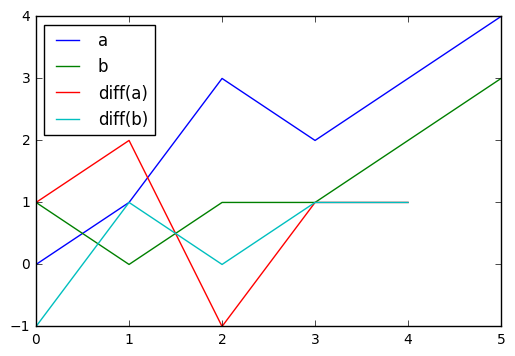

In [113]:
for al in np.linspace(0, 1, 11):
    print("dd_dtw(a, b, alpha={}) = {}".format(al, dd_dtw(a, b, dist=fdtw, alpha=al)))
dd_dtw(a, b, dist=sdtw, toplot=True)

### Derivative Transform Distance
* uses DTW with conjuction of sine, cosine, and Hilbert transforms
* a cosine version transforms vector $a$ into series using
$$c_i=\sum_{k=1}^ma_k\cos\left(\frac{\pi}{2}\left(k-\frac{1}{2}\right)\left(i-1\right)\right)$$

---

All papers claim superiority to DTW
  * results for CID_DTW and DTDC are __significantly__ better than DTW
  * DTDC is significantly more accurate

In [65]:
def cos_transform(a):
    def ci(i):
        cs = 0
        for j in range(a.shape[0]):
            cs += a[i] * np.cos((np.pi / 2) * (j - 1. / 2) * (i - 1))
        return cs
    return np.array([ci(i) for i in range(a.shape[0])])

In [114]:
def dtdc(a, b, dist=fdtw, alpha=1./3, beta=1./3):
    c = np.array([(a[i - 1] - a[i]) for i in range(1, a.shape[0])])
    d = np.array([(b[i - 1] - b[i]) for i in range(1, b.shape[0])])
    e = cos_transform(a)
    f = cos_transform(b)
    x = dist(a, b)
    y = dist(c, d)
    z = dist(e, f)
    return alpha * x + beta * y + (1 - alpha - beta) * z

In [115]:
dtdc(a, b, dist=fdtw)

7.747546895706431

## Dictionary based classifiers
* transform series into representative words
* similarity based on comparing distribution of words
* move w sliding window over series
  * each window produces vector of labels
  * labels discretized by assigning symbols from an alphabet of set size

### Bag Of Patterns BOP
* based on Symbolic Aggregate Approximation SAX
<img src="sax1.png" width="100%" />
  * applies SAX to each window to form a word
  * if consecutive windows produce identical words, only the first is returned
  * distribution of words over a sieries forms a count histogram

In [113]:
def BOP(X, y, w, l, alpha):
    '''
    X: n series of length m each
    y:
    w: window length
    l: word length
    alpha: alphabet size
    '''
    # get n histograms of words over series
    H = np.zeros((X.shape[0], alpha))
    for i in range(X.shape[1]):
        for j in range(X.shape[0]):
            q = X[i, j:j + w + 1]
            r = SAX(q, l, alpha)
            if not trivial_match(r, p):
                # determine location of r in count matrix h
                pos = index(r, h)
                H[i, pos] += 1
            p = r
    return H

### Symbolic Aggregate Approximation Vector Space Model SAXVSM
* combines SAX with vector space used in information retrieval
  * SAXVSM forms words over __classes__ rather than series
  * words are wighted by the ___term frequency - inverse document frequency__ measure
  $$tfidf(tf, df)=\begin{cases}
  \log(1+tf)*log(c/df)&\mbox{if } df>0\\
  0
  \end{cases}$$
  where 
    * $tf$ number of times a word appears in a class
    * $df$ number of classes a word appears in
  

### Bag of SFA symbols BOSS
* uses a truncated Discrete Fourier Tranform DFT over each window
* truncated series is discretized through Multiple Coefficient Binning instead of fixed intervals
* segmented and discretized series, with breakpoints found, are then processed much like BOP

In [115]:
def BOSS(X, y, w, l, alpha):
    # histograms
    H = np.zeros((X.shape[0], alpha))
    # brakpoints
    for i in range(X.shape[1]):
        for j in range(X.shape[0]):
            o = X[i, j:j + w + 1]
            q = DFT(o, l, alpha, p)
            q_first = q[:l/2]
            r = SFA_lookup(q_first, B)
            if not trivial_match(r, p):
                # determine location of r in count matrix h
                pos = index(r, h)
                H[i, pos] += 1
            p = r
    return H, B

### DTW features
* combines DTW distances and SAX histograms

###  Comparisons

<img src="dictionary_ranks.png" width="100%" />

* on 19 data sets using single train/test spli
  * BOP significantly worse than BOSS and SAXVSM
  * no significant differences between DTWF, BOSS, SAXVSM
  * no significant differences between BOSS and DTWF (on larger number o sets)
    * published results of BOSS are probably over-optimistic
      * may include test set optimization 

## Shapelets
* TS subsequences discriminatory of class membership
  * allow phase-independent similarity of series in the same class
  * Keogh and Ye used shapelets as criterions in decision trees

### Fast Shapelets FS
* an extension of a decision tree
* discretizes and approximates shapelets
  * form a dictionary of SAX words for each possible shapelet
  * mask randomly selected letters to reduce dimensionality (random projection)
  * build count histograms for each class
  * find scores how each shapelet discriminates between classes
  * use k-best SAX words

In [117]:
def build_fs(X, y, l, alpha, w, r, k):
    '''
    r: number of random projections
    k: number of SAX words to convert back
    '''
    b = empty_shapelet()
    for l in range(5, X.shape[1]):
        sax_list = create_sax_list(X, y, l, alpha, w)
        sax_map = random_projection(sax_list, r)
        score_list = score_sax(sax_list, sax_map)
        s = find_best_sax(score_list, sax_list, k)
        if b < s:
            b = s
    ((X_left, y_left), (X_right, y_right)) = split_data(X, y)
    if not is_leaf(X_left, y_left):
        build_fs(X_left, y_left)
    if not is_leaf(X_right, y_right):
        build_fs(X_right, y_right)


### Shapelet Transform ST
* find best k shapelets in a single run
* use shapelets to transform data
* transformed data is used to build a classifier
  * use a weighted ensemble of classifiers
    * k-NN, Naive Bayes, C4.5, SVM, Random Forest, Rotation Forest, Bayesian NN
    * each classifier has its weight

In [118]:
def build_st(X, y, min_l, max_l, k, c):
    '''
    min_l, max_l: minimum/maximum shapelet length
    k: number of shapelets to find
    c: number of classes
    '''
    s = set() # set of shapelets
    p = k / c
    for k in range(X.shape[0]):
        (x_this, y_this) = (X[k, :], y[k])
        r = set()
        for l in range(min_l, max_l + 1):
            w = candidates(x_this, y_this, l)
            for a in w:
                d = distances(a, (X, y))
                q = assess(a, d) # find quality of candidate shapelet
                r += (a, q)
        r.sort_by_quality()
        r.remove_self_similar()
        s.merge(p, r)
    return s

### Learned Shapelets LS
* heuristic gradient descent search to discover most informative shapelets
  * shapelets are __not restricted__ to being subseries of training data
  * init by k-means clustering of candidates
  * logistic loss function (with regularization) based on logistic regression for each class
* LS learns regression weights together with shapelets

In [ ]:
def ls(X, y, k, min_l, scale, reg, eta, n_iter, alpha):
    '''
    k: number of shapelets
    min_l: minimum shapelet length
    scale: scale of shapelet length
    reg: regularization parameter
    eta: learning parameter
    n_iter: number of iterations
    alpha: softmax parameter
    '''
    s = init_shapelets_k_means(X, y, k, scale, min_l)
    w = init_weights(X, y, k, scale)
    m = init_model(X, y)
    loss = init_loss()
    for k in range(n_iter):
        m.update(X, y, alpha, min_l, scale)
        loss.update(X, y, m, w)
        w, s = update_w_s(X, y, w, s, eta, scale, min_l, loss, reg, alpha)
        # check if the model has diverged: for some problems LS 
        # may not terminate - a maximum number of restarts is needed
        if m.diverged():
            k = 0
            eta = eta / 3.

###  Known results
* evaluated on 33 common subsets from UCR
<img src="shapelets_ranks.png" width="100%" />
* FS significantly worse
* no significant difference between LS and ST
  * better adaptation in LS possible

## Interval Based Classifiers
* uses features derived from intervals of each series
  * $m(m-1)/2$ contiguous intervals in each $m$-length TS
  * huge dimension increase
  * how to treat each interval
* first propositions
  1. use only intervals of the lengths of power of two
  2. binary features based on thresholds 

### Time Series Forest TSF
* features calculated as summary statiistics (mean, deviation, slope, etc.)
* each member tree uses only $\sqrt{m}$ intervals
  * the split is random

In [119]:
def tsf(X, y, r, min_l):
    '''
    r: number of trees
    min_l: minimum subseries length
    '''
    forest = [tree(k) for k in range(r)]
    m = X.shape[1]
    for i in range(r):
        # select cases with 3 (mean, deviation, slope) x sqrt(m) random features 
        s_features = np.floor(np.sqrt(m))
        (X_s, y_s) = split(X, y, s_features)
        for j in range(s_features):
            # select intervals
            a = np.random.randint(1, m - min_l)
            b = np.random.randint(s + min_l, m)
            for k in range(X.shape[0]):
                X_s[k, 3 * (j - 1) + 0] = np.mean(X[k, :], a, b)
                X_s[k, 3 * (j - 1) + 1] = np.sdev(X[k, :], a, b)
                X_s[k, 3 * (j - 1) + 2] = slope(X[k, :], a, b)
        forest[i] = build_tree_classifier(X_s, y_s)

### Time Series Bag of Features TSBF
* extension of TSF in stages
  1. generate subseries classification problem
    * select $w$ subseries start- and end-points
    * for each subseries take _equal_ width intervals and calculate features (mean, deviation, slope)
    * concatenate features computed, add original class label to form a new training example
  2. produce class probability estimates
    * train a random forest on new subseries dataset
      * add trees incrementally until an out-of-bag error stops decreasing
    * find random forest estimates of class probabilities for each subseries
  3. recombine probabilities and form a bag of patterns
    * discretize class probability estimates into $b$ equal width bins
    * bag together discretized probabilities
  4. build final random forest classifier

### Learned Pattern Similarity LPS
* subseries become attributes
* an internal predictive model built as in TSBF
  * regression model in LPS rather than classification as in TSBF

### Known results
* tested on 44 common data sets
<img src="intervals_ranks.png" width="120%" />
* no significant differences between the methods
  * pairwise comparisons show no differences either


## Ensembles
* some of approaches given are ensembles by itself

### Elastic Ensemble EE
* combination of nearest neighbour classifiers with elastic distance measures
  * __ED__ 1-NN with Euclidean distance
  * __DTW__ and __DTWCV__ Dynamic Time Warping and DTW with window size through CV
  * __DDTW__ and __DDTWCV__ Derivative Time Warping and DTW with window size through CV
  * __WDTW__ and __WDDTW__ weighted DTW and Derivative Weighted DTW
  * __LCSS__ Longest Common Subsequence
  * __ERP__ Edit Distance with Real Penalty
  * __TWE__ Time Warp Edit
  * __MSM__ Move Split Merge distance
* __none__ of the individual members of EE outperforms DTW_CV (Dynamic Time Warping wit Cross Validation with window size set with CV)

### Collective Of Transfometion Ensembles COTE
 * classifiers in time, autocorrealtion, power spectrum, shapelet domain
 * components of EE
 * __35__ classifiers pooled with votes weighted by train set cross validation accuracy

<img src="summary_ensembles.png" width="100%" />
* __NN__ nearest neighbour classification
* __time__ time domain distance function
* __deri__ derivative based distance function
* __shpt__ shapelet based
* __int__ interval
* __dict__ dictionary
* __auto__ auto-correlation based
* __ens__ ensemble

## Comparisons
* 85 datasets from UEA [http://timeseriesclassification.com]
  * length of series from 24 to 2709
  * train set sizes from 16 to 8926
  * number of classes from 2 to 60
  * data from: sensor readings, motion capture, spectrographs, ECG measurements, electric devices, etc.
  
  
* 100 resample folds on each problem for each classifier
* each classifier evaluated 8500 times
  * model selection repeated on every training set fold
  * 850 000 models were built for each classifier
  
* methodology proposed by Demsar used when testing for significant differences between classifiers over various datasets

### Benchmark classifiers tested
* these classifiers take series as vectors
  * do not include time dependecy/auto-correlation/etc.
<img src="benchmark_classifiers_ranks.png" width="100%" />
  * used: Logistic regression, C4.5, Naive Bayes, Bayesian Network, SVM with Linear kernel, 1-NN with Euclidean Distance, Multi-Layer Perceptron, SVM with Quadratic kernel, 1-NN with DTW, Random Forest (500 trees), Rotation Forest (50 trees)
  * RotF and DTW used as benchmarks

### All time-series classifiers
<img src="all_tsc_ranks.png" width="100%" />
* COTE __is significantly__ better than others
  * only nine best shown
  * both EE and ST are elements of COTE
  * this shows the benefits of ensembling
* high rank of BOSS (Bag of SFA Symbols dictionary based approach)

### Comparison by classifier type
#### time domain
* MSM (Move-Split-Merge) has the highest rank
#### difference based
* CID_DTW (complexity Invariant Distance using DTW) and DTD_C (Derivative Transform Distance with cosine transform) are best
* better than benchmark DTW, equal to benchmark RotF
#### dictionary based
* SAXVSM and BOP ranked very low
* at the same time BOSS is one of the best!
  * BOSS uses a Fourier transform
    * BOP is based on Piecewise Aggregate Approximation PAA
  * BOSS uses data driven dicretization
    * BOP uses arbitrary break points
  * which of these differences is the most important?
#### shapelet based
* Fast Shapelets FS is the worse of all classifiers
* Shapelet Transform ST ranks very high
* ST is significantly beter than benchmarks RotF (Rotation Forest) and DTW
#### interval based
* all interval based TSF, TSBF, and LPS are significantly better than benchmarks
* there must be a value in intervals
#### ensemble
* top seven classifiers __are ensembles__
  * diversity, diveristy, diversity!
<img src="summary_table.png" width="100%" />


* The accuracy __may depend__ on the type of problem
  * which algorithm types work best on which type of data?

* the computational complexity is very different

# How to choose a model?
* start with Dynamic Warping, Rotation Forest, Random Forest
  * as benchmarks
  * for sanity
* check the type of discriminatory features
  * if embedded in subseries, then choose shapelet ST or interval based TSF
  * if in frequency domain, then choose BOSS